In [40]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Import Liberaries

In [ ]:
!pip install netCDF4 netCDF4 wxee geemap rioxarray rasterio geopandas

In [41]:
import os
import sys
import pandas as pd
import numpy as np
import netCDF4 as nc
import xarray as xr
import netCDF4 as gpd
import ee
import wxee
import geemap
import rioxarray
import rasterio
import pickle
import geopandas as gpd

sys.path.append('/content/drive/MyDrive/WaterBalance/')

from qdwb.primary_surface_flow.primary_surface_flow import *
from qdwb.primary_surface_flow.asset import *
from qdwb.coordinate.extract import *

In [42]:
ee.Authenticate()
wxee.Initialize()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://code.earthengine.google.com/client-auth?scopes=https%3A//www.googleapis.com/auth/earthengine%20https%3A//www.googleapis.com/auth/devstorage.full_control&request_id=110bG_yplGFd796amKKGBenqnvkLTwC4Su3nF7PbZT4&tc=zWM5U5WDcBJ07M83yVvi6WAECsHe9SUfqikjorrdyFo&cc=7aGKoJlUInh0SGeaUHGZsdmfH5A6ICEWXikUSClwcpI

The authorization workflow will generate a code, which you should paste in the box below.
Enter verification code: 4/1AbUR2VN3Bts0DDlEK2fUUkdBQMACl1x_TmsouiID3wQnH0p_UZZK4-smRh0

Successfully saved authorization token.


# Varables

In [43]:
PATH_DATA = "/content/drive/MyDrive/WaterBalance/assets/"

# mashhad
# LAT_MIN = 35.80
# LAT_MAX = 37.11
# LON_MIN = 58.31
# LON_MAX = 60.14

# USA
LAT_MIN = 43.30
LAT_MAX = 44.60
LON_MIN = -109.40
LON_MAX = -107.40


# Functions

In [44]:
def mask_nc_file(
    nc,
    variable,
    lat_min,
    lat_max,
    lon_min,
    lon_max
):
    with xr.open_dataset(nc) as xr_nc:
        result = xr_nc.sel(
            lat = slice(lat_max, lat_min),
            lon = slice(lon_min, lon_max),
        )
    return result

# Load Data

In [45]:
# mm d-1 - precipitation
P = mask_nc_file(
    nc = PATH_DATA + "nc/P_2022031.nc",
    variable = "precipitation",
    lat_min = LAT_MIN,
    lat_max = LAT_MAX,
    lon_min = LON_MIN,
    lon_max = LON_MAX
)
 
# mashhad = gpd.read_file('/mnt/e/Term2/WERI/test/Export_Output.shp')

usa = gpd.read_file(PATH_DATA + "shape/usa.shp")


In [46]:


# Map = geemap.Map()
# Map.add_basemap('HYBRID')


shape = ee.Geometry.Rectangle([LON_MAX,LAT_MIN,LON_MIN,LAT_MAX])


# Import the GCN250 Images and rename bands
# GCN250_Average =  ee.Image("users/jaafarhadi/GCN250/GCN250Average").select('b1').rename('average')
CN_Wyoming =  ee.Image("users/jaafarhadi/GCN250/GCN250Dry").select('b1').rename('dry')
# GCN250_Wet = ee.Image("users/jaafarhadi/GCN250/GCN250Wet").select('b1').rename('wet')


CN_Wyoming = CN_Wyoming.clip(shape)
 
# Map.centerObject(shape, 9)
# Map.addLayer(CN_Wyoming, {'min':40, 'max':75, 'palette': ['Red','SandyBrown','Yellow','LimeGreen', 'Blue','DarkBlue']}, 'CN_Wyoming')
# Map

In [47]:
CN_Wyoming = CN_Wyoming.set("system:time_start", ee.Date("2015"))
arr = CN_Wyoming.wx.to_xarray(scale=250, crs='EPSG:4326')
arr

Downloading:   0%|          | 0.00/64.1k [00:00<?, ?iB/s]

<xarray.Dataset>
Dimensions:  (time: 1, y: 582, x: 892)
Coordinates:
  * time     (time) datetime64[ns] 2015-01-01
  * y        (y) float64 44.6 44.6 44.6 44.6 44.6 ... 43.31 43.31 43.3 43.3 43.3
  * x        (x) float64 -109.4 -109.4 -109.4 -109.4 ... -107.4 -107.4 -107.4
Data variables:
    dry      (time, y, x) float64 nan nan nan nan nan ... 59.0 59.0 59.0 59.0
Attributes:
    transform:               (0.002245788210298804, 0.0, -109.40132687649593,...
    crs:                     +init=epsg:4326
    res:                     (0.002245788210298804, 0.002245788210298804)
    is_tiled:                1
    nodatavals:              (-32768.0,)
    scales:                  (1.0,)
    offsets:                 (0.0,)
    AREA_OR_POINT:           Area
    TIFFTAG_RESOLUTIONUNIT:  1 (unitless)
    TIFFTAG_XRESOLUTION:     1
    TIFFTAG_YRESOLUTION:     1

## reroject CN array accoring to precipitation array

In [48]:

da = arr.rio.write_crs("epsg:4326", inplace=True)

P.rio.write_crs("epsg:4326", inplace=True)

p = P.rename({'lon': 'x','lat': 'y'})

xds_repr_match = da.rio.reproject_match(p, resampling = rasterio.enums.Resampling.nearest)
xds_repr_match


<xarray.Dataset>
Dimensions:      (x: 20, y: 13, time: 1)
Coordinates:
  * x            (x) float32 -109.3 -109.2 -109.1 ... -107.6 -107.5 -107.4
  * y            (y) float32 44.55 44.45 44.35 44.25 ... 43.65 43.55 43.45 43.35
  * time         (time) datetime64[ns] 2015-01-01
    spatial_ref  int64 0
Data variables:
    dry          (time, y, x) float64 53.0 53.0 55.0 57.0 ... 64.0 64.0 64.0
Attributes:
    transform:               (0.002245788210298804, 0.0, -109.40132687649593,...
    res:                     (0.002245788210298804, 0.002245788210298804)
    is_tiled:                1
    nodatavals:              (-32768.0,)
    scales:                  (1.0,)
    offsets:                 (0.0,)
    AREA_OR_POINT:           Area
    TIFFTAG_RESOLUTIONUNIT:  1 (unitless)
    TIFFTAG_XRESOLUTION:     1
    TIFFTAG_YRESOLUTION:     1

## plot reprojected CN array

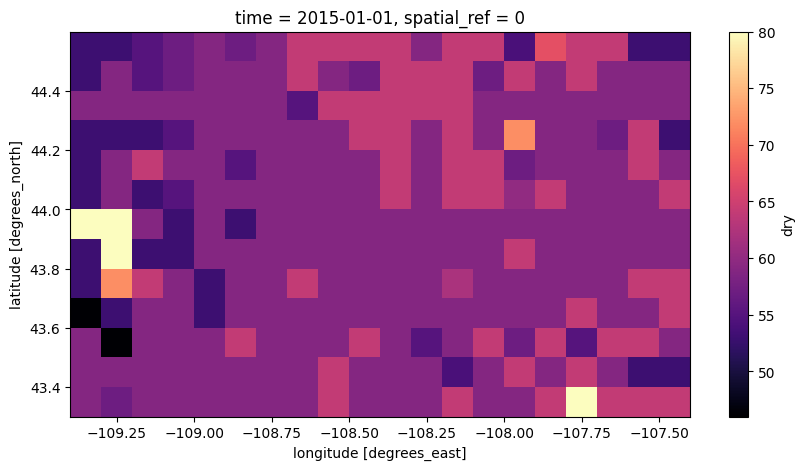

In [49]:
xds_repr_match.dry.plot(figsize=(10, 5), cmap="magma")

In [50]:
cn =list(xds_repr_match.dry.values.flatten())
pre =list(p.precipitation.values.flatten())

np.array([PrimarySurfaceFlow.scs(
    precipitation = float(i),
    curve_number = float(j),
    rsa = True,
    antecedent_precipitation = 100,
    is_growing_season = True
)
for i, j in zip(pre,cn)])

# underground_runoff = np.array([PrimarySurfaceFlow.scs(
#     precipitation = float(i),
#     curve_number = float(j),
#     rsa = True,
#     antecedent_precipitation = 100,
#     is_growing_season = True
# )[1]
# for i, j in zip(pre,cn)])

# R_array = R.reshape(1,13,20)
# underground_runoff_array = underground_runoff.reshape(1,13,20)


# ds_array = p.assign(Runoff=(['time', 'y', 'x'], R_array))
# ds_array_1 = ds_array.assign(underground_runoff=(['time', 'y', 'x'], underground_runoff_array))
# ds_array_1.Runoff.plot()


array([[4.65433896, 0.        ],
       [4.65433896, 0.        ],
       [4.30987312, 0.        ],
       [4.13045774, 0.        ],
       [3.80208382, 0.        ],
       [4.1655225 , 0.        ],
       [3.83714075, 0.        ],
       [3.10597826, 0.        ],
       [3.10597826, 0.        ],
       [3.10597826, 0.        ],
       [3.10597826, 0.        ],
       [3.83714075, 0.        ],
       [3.10597826, 0.        ],
       [3.10597826, 0.        ],
       [4.7037037 , 0.        ],
       [2.54736289, 0.        ],
       [2.93324827, 0.        ],
       [2.89942909, 0.        ],
       [4.65433896, 0.        ],
       [4.65433896, 0.        ],
       [4.68849029, 0.        ],
       [3.62976047, 0.        ],
       [4.30987312, 0.        ],
       [4.13045774, 0.        ],
       [3.80208382, 0.        ],
       [3.83714075, 0.        ],
       [3.83714075, 0.        ],
       [3.10597826, 0.        ],
       [3.83714075, 0.        ],
       [4.1655225 , 0.        ],
       [3.

In [51]:
# Map = geemap.Map()
# Map.add_basemap('HYBRID')

soilmoisture = ee.ImageCollection('NASA_USDA/HSL/SMAP10KM_soil_moisture').filter(ee.Filter.date('2022-01-31T00:00:00', '2022-02-01T00:00:00')).select('ssm').mean().clip(shape)

sub_soilmoisture = ee.ImageCollection('NASA_USDA/HSL/SMAP10KM_soil_moisture').filter(ee.Filter.date('2022-01-31T00:00:00', '2022-02-01T00:00:00')).select('susm').mean().clip(shape)
# Map.centerObject(shape, 9)
# Map.addLayer(soilmoisture, {'min':0, 'max':28, 'palette': ['0300ff', '418504', 'efff07', 'efff07', 'ff0303']}, 'soilmoisture')
# Map

In [52]:
soilmoisture = soilmoisture.set("system:time_start", ee.Date("2022"))
sub_soilmoisture = sub_soilmoisture.set("system:time_start", ee.Date("2022"))


arr_soilmoisture = soilmoisture.wx.to_xarray(scale=10000, crs='EPSG:4326')
arr_sub_soilmoisture = sub_soilmoisture.wx.to_xarray(scale=10000, crs='EPSG:4326')
arr_sub_soilmoisture

Downloading:   0%|          | 0.00/1.79k [00:00<?, ?iB/s]

Downloading:   0%|          | 0.00/1.80k [00:00<?, ?iB/s]

<xarray.Dataset>
Dimensions:  (time: 1, y: 15, x: 23)
Coordinates:
  * time     (time) datetime64[ns] 2022-01-01
  * y        (y) float64 44.6 44.51 44.42 44.33 ... 43.61 43.52 43.43 43.34
  * x        (x) float64 -109.4 -109.3 -109.2 -109.1 ... -107.6 -107.5 -107.4
Data variables:
    susm     (time, y, x) float32 69.84 69.84 79.21 49.7 ... 48.75 48.75 80.62
Attributes:
    transform:               (0.08983152841195215, 0.0, -109.41480160575772, ...
    crs:                     +init=epsg:4326
    res:                     (0.08983152841195215, 0.08983152841195215)
    is_tiled:                1
    nodatavals:              (-32768.0,)
    scales:                  (1.0,)
    offsets:                 (0.0,)
    AREA_OR_POINT:           Area
    TIFFTAG_RESOLUTIONUNIT:  1 (unitless)
    TIFFTAG_XRESOLUTION:     1
    TIFFTAG_YRESOLUTION:     1

In [53]:
da_soilmoisture = arr_soilmoisture.rio.write_crs("epsg:4326", inplace=True)
da_sub_soilmoisture = arr_sub_soilmoisture.rio.write_crs("epsg:4326", inplace=True)

xds_repr_match__soilmoisture = da_soilmoisture.rio.reproject_match(p, resampling = rasterio.enums.Resampling.nearest)
xds_repr_match__sub_soilmoisture = da_sub_soilmoisture.rio.reproject_match(p, resampling = rasterio.enums.Resampling.nearest)

xds_repr_match__sub_soilmoisture

<xarray.Dataset>
Dimensions:      (x: 20, y: 13, time: 1)
Coordinates:
  * x            (x) float32 -109.3 -109.2 -109.1 ... -107.6 -107.5 -107.4
  * y            (y) float32 44.55 44.45 44.35 44.25 ... 43.65 43.55 43.45 43.35
  * time         (time) datetime64[ns] 2022-01-01
    spatial_ref  int64 0
Data variables:
    susm         (time, y, x) float32 67.88 67.88 46.5 ... 66.51 48.75 48.75
Attributes:
    transform:               (0.08983152841195215, 0.0, -109.41480160575772, ...
    res:                     (0.08983152841195215, 0.08983152841195215)
    is_tiled:                1
    nodatavals:              (-32768.0,)
    scales:                  (1.0,)
    offsets:                 (0.0,)
    AREA_OR_POINT:           Area
    TIFFTAG_RESOLUTIONUNIT:  1 (unitless)
    TIFFTAG_XRESOLUTION:     1
    TIFFTAG_YRESOLUTION:     1

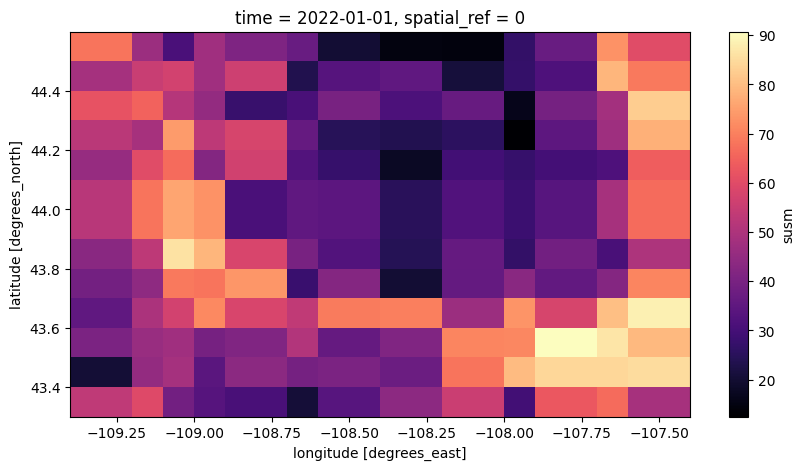

In [54]:
xds_repr_match__sub_soilmoisture.susm.plot(figsize=(10, 5), cmap="magma")

In [55]:
cn = list(xds_repr_match.dry.values.flatten())
pre = list(p.precipitation.values.flatten())
soil = list(xds_repr_match__soilmoisture.ssm.values.flatten())
sub_soil = list(xds_repr_match__sub_soilmoisture.susm.values.flatten())

runoff_array = np.array([PrimarySurfaceFlow.scs(
    precipitation = float(i),
    curve_number = float(j),
    rsa = True,
    antecedent_precipitation = float(z),
    is_growing_season = True
)[0]
for i, j, z in zip(pre, cn, soil)])

underground_runoff_array = np.array([PrimarySurfaceFlow.scs(
    precipitation = float(i),
    curve_number = float(j),
    rsa = True,
    antecedent_precipitation = float(z),
    is_growing_season = True
)[1]
for i, j, z in zip(pre, cn, soil)])

soil_array = np.array(soil)
sub_soil_array = np.array(sub_soil)


runoff_array = runoff_array.reshape(1,13,20)
underground_runoff_array = underground_runoff_array.reshape(1,13,20)
soil_array = soil_array.reshape(1,13,20)
sub_soil_array = sub_soil_array.reshape(1,13,20)

ds_array = p.assign(runoff=(['time', 'y', 'x'], runoff_array))
ds_array_1 = ds_array.assign(underground_runoff=(['time', 'y', 'x'], underground_runoff_array))
ds_array_2 = ds_array_1.assign(soilmoisture=(['time', 'y', 'x'], soil_array))
ds_array_3 = ds_array_2.assign(sub_soilmoisture=(['time', 'y', 'x'], sub_soil_array))


ds_array_3



<xarray.Dataset>
Dimensions:             (x: 20, y: 13, time: 1)
Coordinates:
  * x                   (x) float32 -109.3 -109.2 -109.1 ... -107.5 -107.4
  * y                   (y) float32 44.55 44.45 44.35 ... 43.55 43.45 43.35
  * time                (time) datetime64[ns] 2022-01-31
    spatial_ref         int64 0
Data variables:
    precipitation       (time, y, x) float32 0.4375 0.4375 0.375 ... 0.0 0.0 0.0
    runoff              (time, y, x) float64 11.02 11.02 10.18 ... 17.01 17.01
    underground_runoff  (time, y, x) int64 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0
    soilmoisture        (time, y, x) float32 24.87 24.87 16.27 ... 12.07 12.07
    sub_soilmoisture    (time, y, x) float32 67.88 67.88 46.5 ... 48.75 48.75
Attributes:
    history:          Created on 2022-02-05 07:15
    input_data_hash:  27d78e1ad0241438dcb7b796dee6d7c1393f1b4522680997748376e...

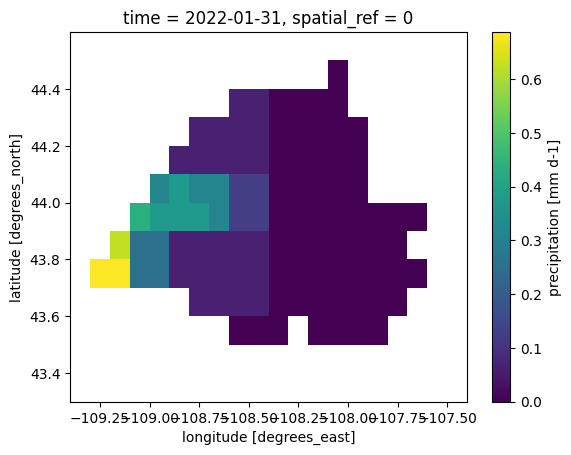

In [57]:


shp_dir = PATH_DATA + "shape/usa.shp"
shapefile = gpd.read_file(shp_dir)


precip_da = add_shape_coord_from_data_array(ds_array_3, shp_dir, "shapefile")
ds_array_4 = ds_array_3.where(precip_da.shapefile==0, other=np.nan)



with open('/content/drive/MyDrive/WaterBalance/notebook/ds_array_4.pkl', 'wb') as f:
    pickle.dump(ds_array_4, f)

ds_array_4.precipitation.plot()


In [ ]:
Map = geemap.Map()
Map.add_basemap('HYBRID')

dem = ee.Image("USGS/SRTMGL1_003").clip(shape)

Map.centerObject(shape, 9)
Map.addLayer(ee_object = dem, vis_params = {'min':-10, 'max':6500}, name = 'dem')
Map

Map(center=[43.95199004841242, -108.40000000000003], controls=(WidgetControl(options=['position', 'transparent…